In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from flask import Flask, request, jsonify
import time

# Generate a sample dataset for predictive maintenance
np.random.seed(42)

# Generate a shorter time range (24 hours)
date_range = pd.date_range(start="2023-01-01", periods=24, freq="H")

# Generate random sensor data with more variation
temperature = np.random.normal(loc=75, scale=15, size=len(date_range)).round(2)
vibration = np.random.normal(loc=5, scale=2.0, size=len(date_range)).round(2)
pressure = np.random.normal(loc=100, scale=20, size=len(date_range)).round(2)

<ipython-input-7-6a11f6e2b128>:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start="2023-01-01", periods=24, freq="H")


In [8]:
failure = np.array([1 if (t > 80 and v > 6 and p > 110) else 0
                    for t, v, p in zip(temperature, vibration, pressure)])

# Introduce more random noise to increase faults
random_failures = np.random.choice([0, 1], size=len(failure), p=[0.8, 0.2])
failure = np.where((failure == 0) & (random_failures == 1), 1, failure)

# Create a DataFrame
predictive_maintenance_data = pd.DataFrame({
    "timestamp": date_range,
    "temperature": temperature,
    "vibration": vibration,
    "pressure": pressure,
    "failure": failure
})



In [9]:
# Data Preprocessing
data = predictive_maintenance_data.drop(columns=["timestamp"])
X = data.drop(columns=["failure"])
y = data["failure"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Model Training with RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Model saved as 'predictive_maintenance_model.pkl'


<ipython-input-10-9b25c4941ff9>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


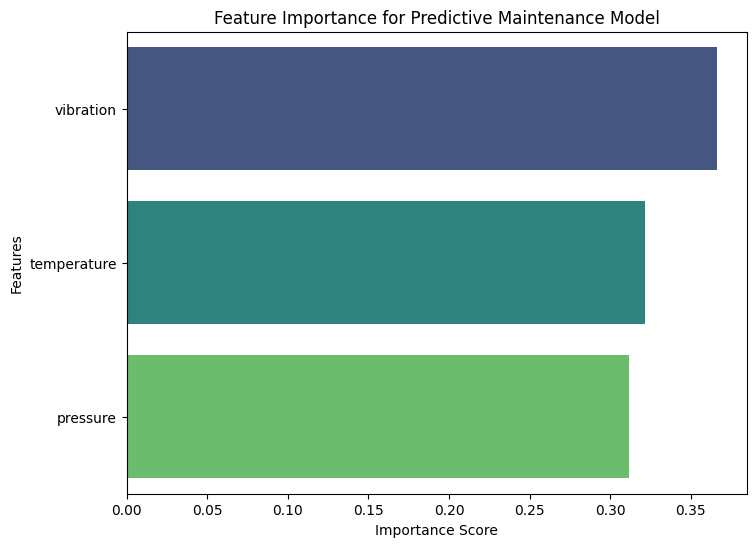

In [10]:
# Save the model for deployment
joblib.dump(model, 'predictive_maintenance_model.pkl')
print("Model saved as 'predictive_maintenance_model.pkl'")

# Feature Importance Analysis
feature_importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance for Predictive Maintenance Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [ ]:
# Flask API with Timing Feature
app = Flask(__name__)

@app.route('/predict-failure', methods=['POST'])
def predict_failure_with_unique_timing():
    start_time = time.time()  # Start the timer
    data = request.get_json()
    input_data = pd.DataFrame([data])

    # Predict using the model
    prediction = model.predict(input_data)[0]
    result = "Failure Predicted" if prediction == 1 else "No Failure Predicted"

    end_time = time.time()  # End the timer
    prediction_time = (end_time - start_time) * 1000  # Convert to milliseconds

    # Return the prediction and the time taken
    return jsonify({
        'prediction': result,
        'prediction_time_ms': f'{prediction_time:.2f} ms'
    })

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
